In [1]:
##导入包
import anndata
import scvelo as scv
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib as plt
from matplotlib import rcParams
%load_ext rpy2.ipython


In [2]:
## 加载已保存数据，可以直接绘图
## germcells = anndata.read_h5ad('germcells.h5ad')

In [2]:
## 读取剪切与未剪切RNA的 loom 文件， UAMP 坐标文件； Seurat cluster 信息； 颜色信息； 细胞类型信息
## loom 文件
germcells = anndata.read_loom("./input_loom/merged.loom")
## UMAP 坐标
umap = pd.read_csv("./coordinate_data/cell_embeddings.csv")
## cluster 信息
cell_clusters = pd.read_csv("./coordinate_data/clusters.csv",dtype='str')
##颜色信息
my_color = pd.read_csv("./coordinate_data/mycolor.csv")
##细胞类型信息
my_stage = pd.read_csv("./coordinate_data/mystage.csv")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
## 需要对germcells提取子集
germcells = germcells[umap["Cell ID"]]
germcells

View of AnnData object with n_obs × n_vars = 1526 × 31053
    obs: 'Clusters', '_X', '_Y'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [6]:
##提取index并将行名命名为'Cell ID'
germcells_index = pd.DataFrame(germcells.obs.index)
germcells_index = germcells_index.rename(columns = {0:'Cell ID'})

In [7]:
###将umap坐标对应并导入germcells
## 将索引dataframe与UMAP合并，将 umap 的顺序与 annadata 中的Cell ID对应起来
umap = germcells_index.merge(umap,on="Cell ID")
## 去掉Cell ID这一列
umap=umap.drop(columns=["Cell ID"])
## 将UMAP 坐标写入germcells
germcells.obsm['X_umap'] = umap.values

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [9]:
germcells.obsm['X_umap']

array([[ 4.82233227,  0.57251318],
       [ 3.88272656,  1.59295769],
       [ 4.22736252, -0.51550256],
       ...,
       [-0.87950789, -3.43752341],
       [-4.33511578, -1.0218948 ],
       [ 2.66199244,  1.49293013]])

In [14]:
#cell_clusters = pd.read_csv("./coordinate_data/clusters.csv",dtype='str')
cell_clusters = cell_clusters.drop(columns=["Cell ID"])
cell_clusters
germcells.obs['seurat_cluster'] = cell_clusters.values
germcells.obs['seurat_cluster']

GR11:AAACCTGGTACTCAACx    2
GR11:AAAGATGAGTCCAGGAx    2
GR11:AAAGATGTCACATAGCx    2
GR11:AAATGCCGTATATGGAx    2
GR11:AACCGCGTCATAACCGx    2
                         ..
GR13:TTTCCTCCAAGAGGCTx    0
GR13:TTTCCTCGTGGTTTCAx    3
GR13:TTTGGTTCAGATCTGTx    1
GR13:TTTGGTTCATGTCGATx    0
GR13:TTTGTCAAGAGCTGGTx    0
Name: seurat_cluster, Length: 1526, dtype: object

In [15]:
my_color = germcells_index.merge(my_color,on="Cell ID")
my_color = my_color.drop(columns=["Cell ID"])
germcells.uns['mycolor'] = my_color   ##这里不需要.value,不知是否与uns有关

In [17]:
my_stage = germcells_index.merge(my_stage,on="Cell ID")
my_stage = my_stage.drop(columns=["Cell ID"])
germcells.obs['my_group'] = my_stage.values

In [18]:
## Running RNA Velocity
scv.pp.filter_and_normalize(germcells)
scv.pp.moments(germcells)
scv.tl.velocity(germcells, mode = "stochastic")
scv.tl.velocity_graph(germcells)
# scv.pl.velocity_embedding(sample_one, basis='umap')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_scVelo_cluster.pdf


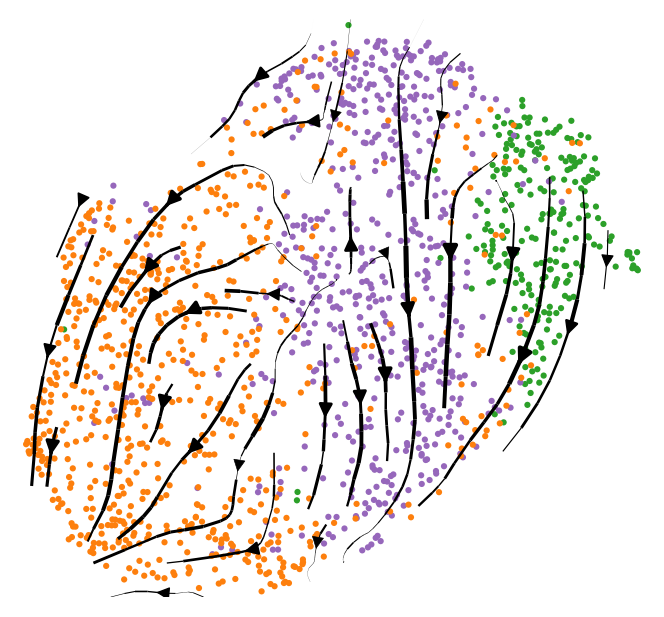

In [19]:
scv.settings.set_figure_params(figsize=(4,3.8),dpi=100,vector_friendly=True)
scv.pl.velocity_embedding_stream(germcells, basis='umap', 
                                 color=germcells.uns["mycolor"],
                                 colorbar=False ,## 去掉colorbar
                                 frameon=None, 
                                 legend_loc='none',
                                 legend_fontweight=0,
                                density=0.3, ## 箭头密度
                                size=20,  ## 点大小
                                 n_neighbors=None,
                                 groups=None,
                                 alpha=1,  ## 点透明度
                                save="scVelo_cluster.pdf")

In [20]:
## 保存数据
germcells.write(filename='germcells.h5ad')

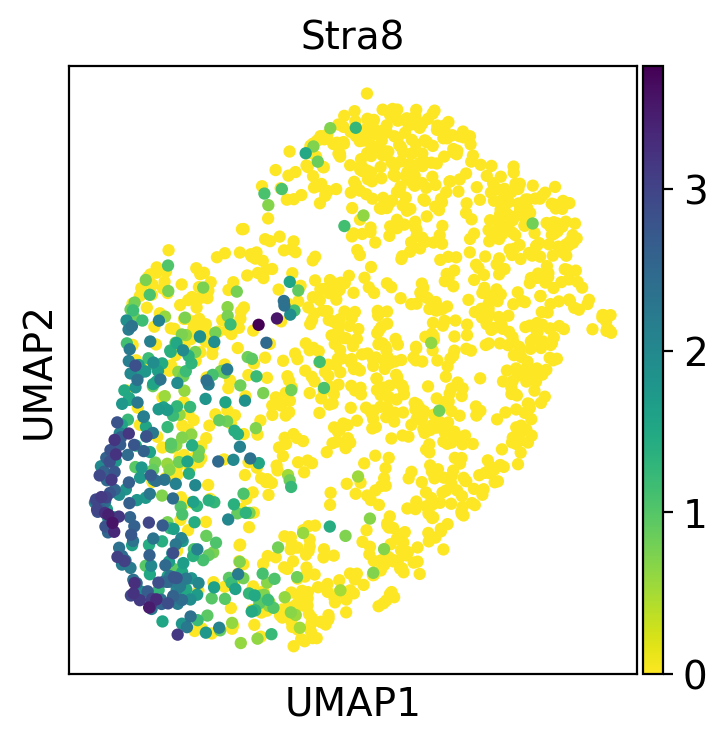

In [33]:
sc.set_figure_params(dpi=100, color_map = 'viridis_r')
sc.settings.verbosity = 1
#sc.logging.print_versions()
## 1. Visualization of gene expression and other variables
# rcParams is used for the figure size, in this case 4x4
rcParams['figure.figsize'] = 4, 4
sc.pl.umap(germcells, color='Stra8')

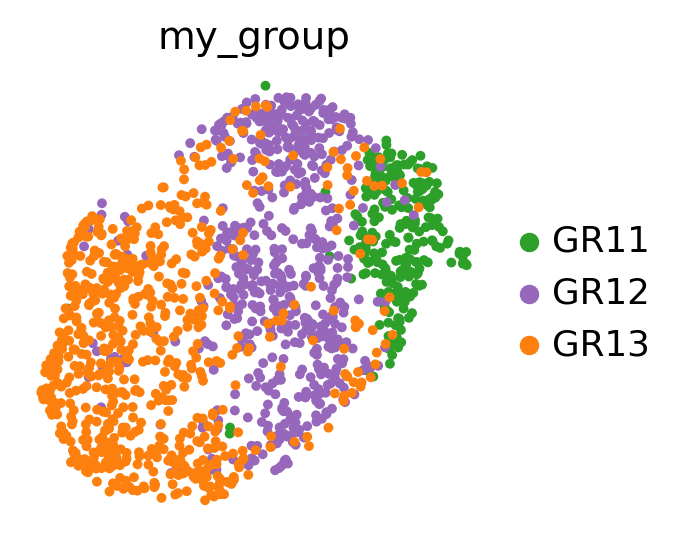

In [39]:
#Also, we are using frameon=False to remove the boxes around the plots and s=50 to set the dot size.
rcParams['figure.figsize'] = 3,3
sc.pl.umap(germcells, color=['my_group'], s=50, frameon=False, ncols=3, vmax='p99',palette=["#2CA029","#9667BB","#FD7F0D"])

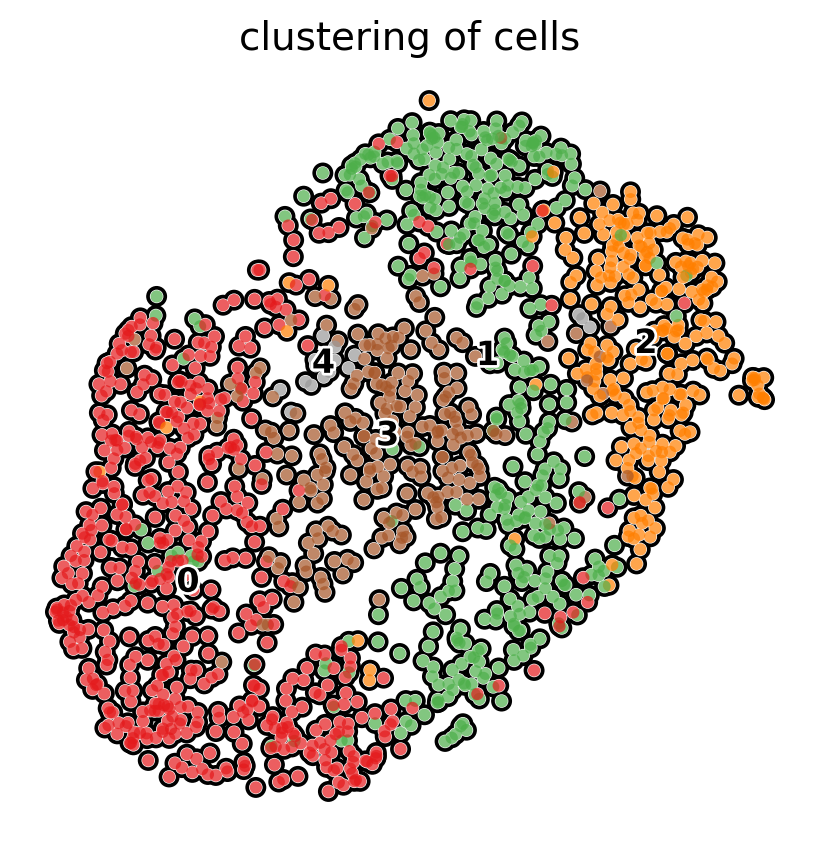

In [35]:
# compute clusters using the leiden method and store the results with the name `clusters`
sc.tl.leiden(germcells, key_added='clusters', resolution=0.5)

rcParams['figure.figsize'] = 5, 5
sc.pl.umap(germcells, color='clusters', add_outline=True, legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2,frameon=False,
           title='clustering of cells', palette='Set1')

In [40]:
scv.pl.velocity_embedding(germcells, arrow_length=3, arrow_size=2, dpi=120)

SyntaxError: positional argument follows keyword argument (<ipython-input-40-4caca7779061>, line 1)

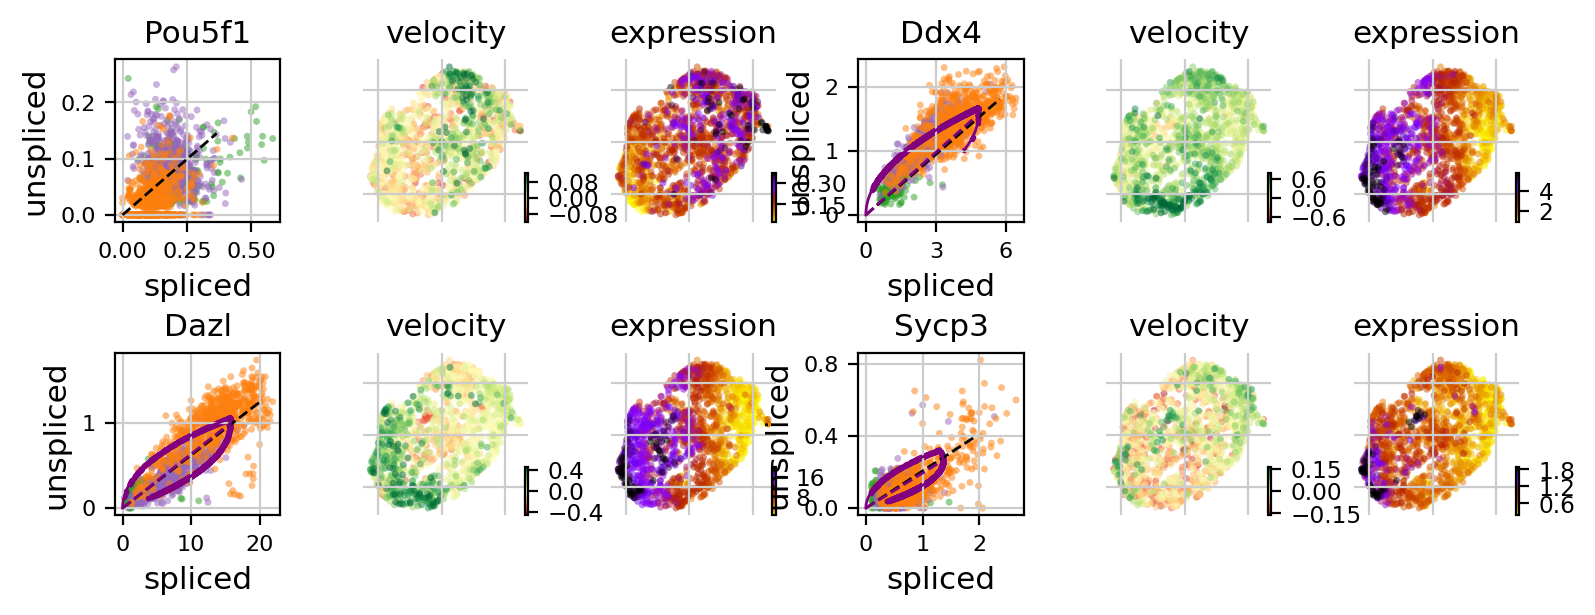

In [48]:
scv.pl.velocity(germcells, ['Pou5f1',  'Ddx4', 'Dazl', 'Sycp3'],color='my_group',ncols=2)

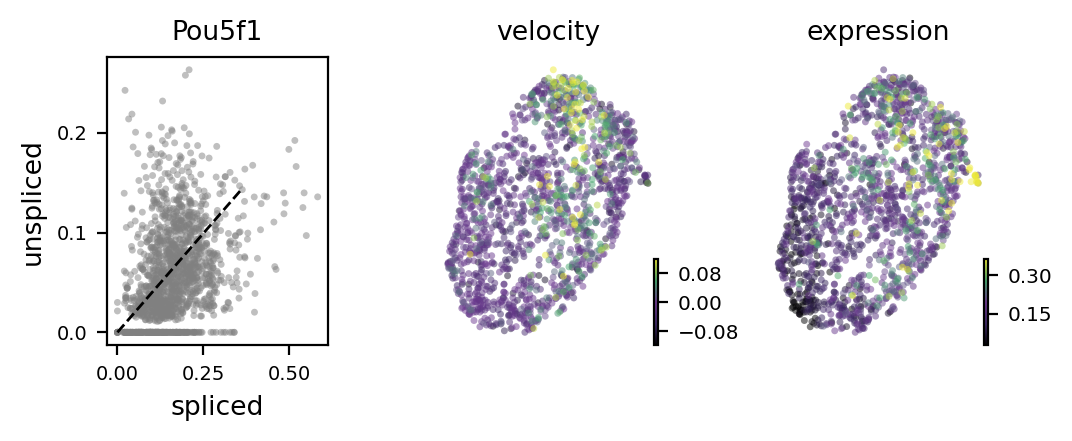

In [24]:
scv.pl.velocity(germcells, ['Pou5f1'],color_map=[('black','#3D2966','#6F3B92','#48AA70','#EEEA38')], ncols=2)

In [25]:
scv.tl.recover_dynamics(germcells)

recovering dynamics
    finished (0:04:00) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


computing latent time using my_group as prior
    finished (0:00:02) --> added 
    'latent_time', shared time (adata.obs)
saving figure to file ./figures/scvelo_latenttime.pdf


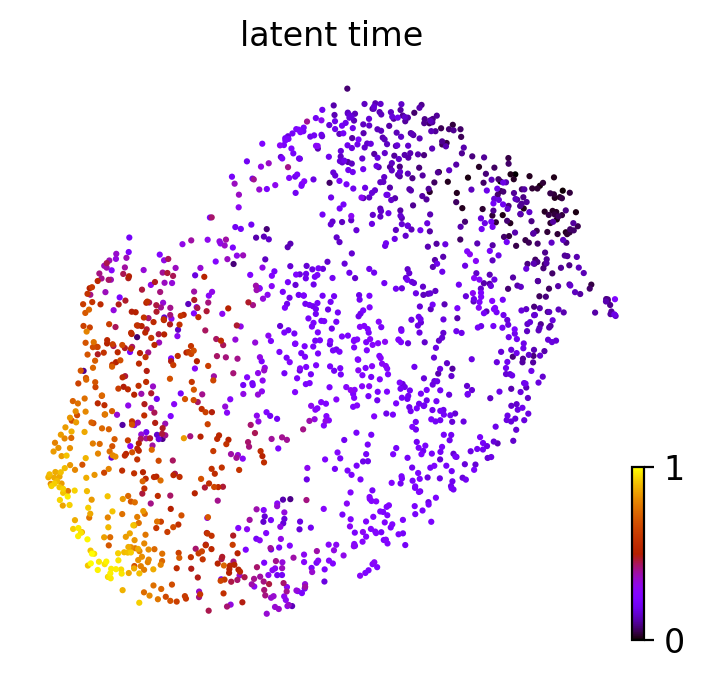

In [26]:
scv.settings.set_figure_params(figsize=(4,3.8),vector_friendly=False)
scv.tl.latent_time(germcells,root_key="my_group")
scv.pl.scatter(germcells, color='latent_time', color_map='gnuplot',size=20,save="latenttime.pdf")

saving figure to file ./figures/scvelo_heatmap_heatmap.pdf


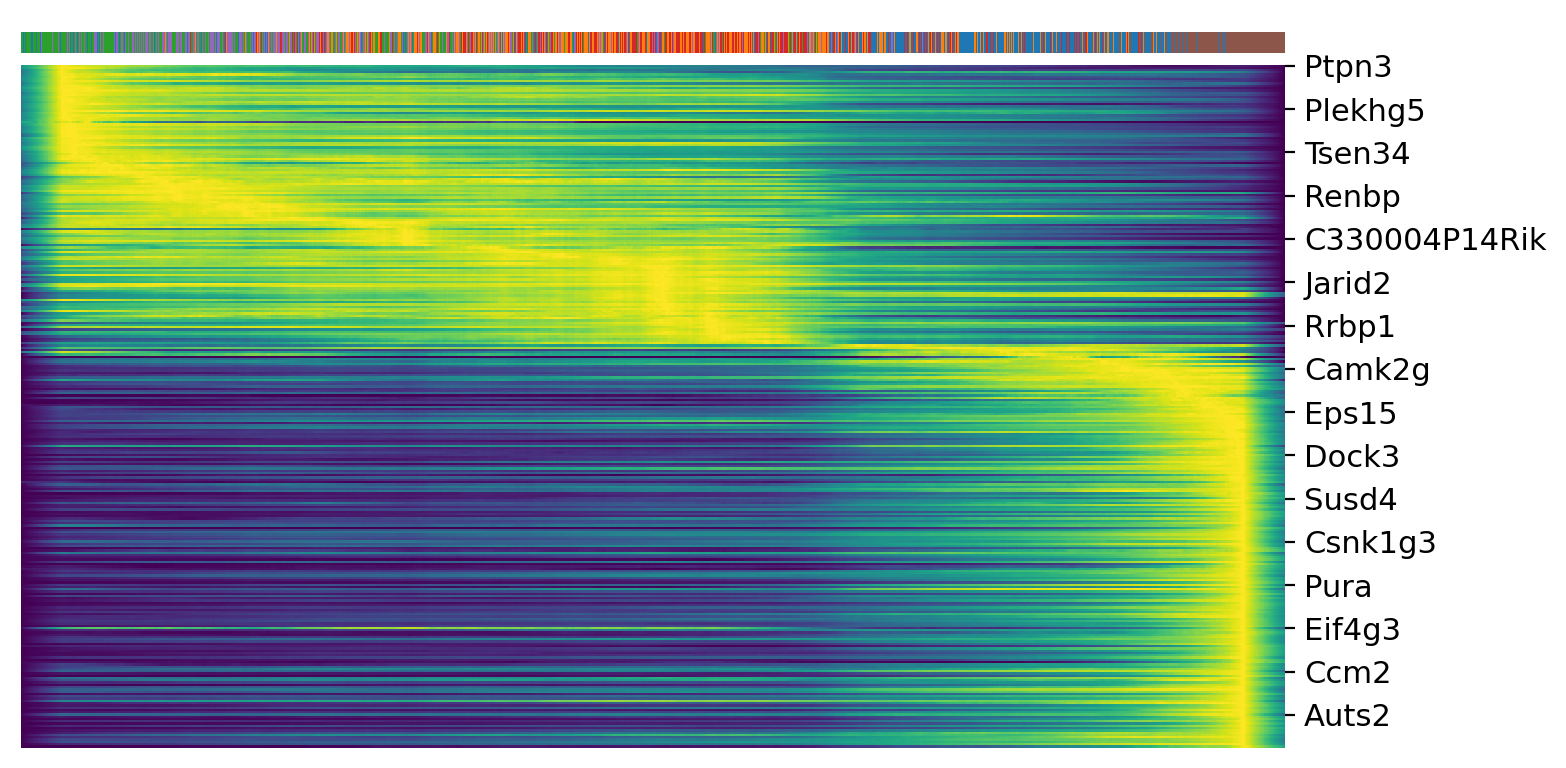

In [27]:
top_genes = germcells.var['fit_likelihood'].sort_values(ascending=False).index[:300]
scv.settings.set_figure_params(figsize=(4,3.8),dpi_save=1000,vector_friendly=False)
scv.pl.heatmap(germcells, var_names=top_genes, sortby='latent_time',col_color='seurat_cluster', n_convolve=100,save='heatmap.pdf')

In [28]:
germcells

AnnData object with n_obs × n_vars = 1526 × 31053
    obs: 'Clusters', '_X', '_Y', 'seurat_cluster', 'my_group', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'velocity_pseudotime', 'latent_time'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'velocity_gamma', 'velocity_r2', 'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling'
    uns: 'mycolor', 'pca', 'neighbors', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'recover_dynamics', 'seurat_cluster_colors'
    obsm: 'X_umap', 'X_pca', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity', 'fit_t', 'fit_tau', 'fit_tau_'
    obsp: 'distances', 'connectivities'

In [29]:
scv.tl.rank_dynamical_genes(germcells, groupby='my_group')
df = scv.get_df(germcells, 'rank_dynamical_genes/names')
df.head(30)

ranking genes by cluster-specific likelihoods
    finished (0:00:01) --> added 
    'rank_dynamical_genes', sorted scores by group ids (adata.uns)


GR11           GR12      GR13
0           Cenpf           Ddx4     Cenpf
1         Gm26805          Uqcrq     Cpeb1
2           Kdm2b           Dazl     Uqcrq
3           Ehmt1          Cpeb1     Dmrt1
4   4932438A13Rik          Dmrt1      Etv5
5           Mkrn1  4932438A13Rik     Stk31
6             Pml          Qser1      Dazl
7           Cpeb1          Smc1b      Helz
8            Ddx4         Tsen34      Ddx4
9           Sash1       Prelid3a  Prelid3a
10           Tle4          Scml2     Mkrn1
11           Jak1          Stk31     Qtrt1
12            Tes         Camk2g      Cdc6
13        Dennd5a          Qtrt1     Zfp42
14         Tomm40         Map7d2    Tsen34
15          Aurka        Fam117b     Ssbp4
16          Cdc26          Ehmt1     Fstl1
17          Cep57          Kdm2b    Gm1673
18        St3gal5        Dennd5a    Map7d2
19          Wdr26         Tomm40     Stra8
20          Zfp42         Gm1673       Pml
21        Ctnnal1          Eps15     Aurka
22          Usp10          Mkrn1     Cdc26
23         Klhl13          Btbd7    Txnrd1
24          Spast           Usp3       Ina
25          Bod1l           Etv5    Rnf130
26          Ptpre          Dcaf5     Ehmt1
27          Ptpn3           Add3   Ctnnal1
28          Spdl1          Cenpf    Camk2g
29         Elovl6           Fut8     Qser1

In [30]:
df.to_csv("velocity_markers_stage.csv")

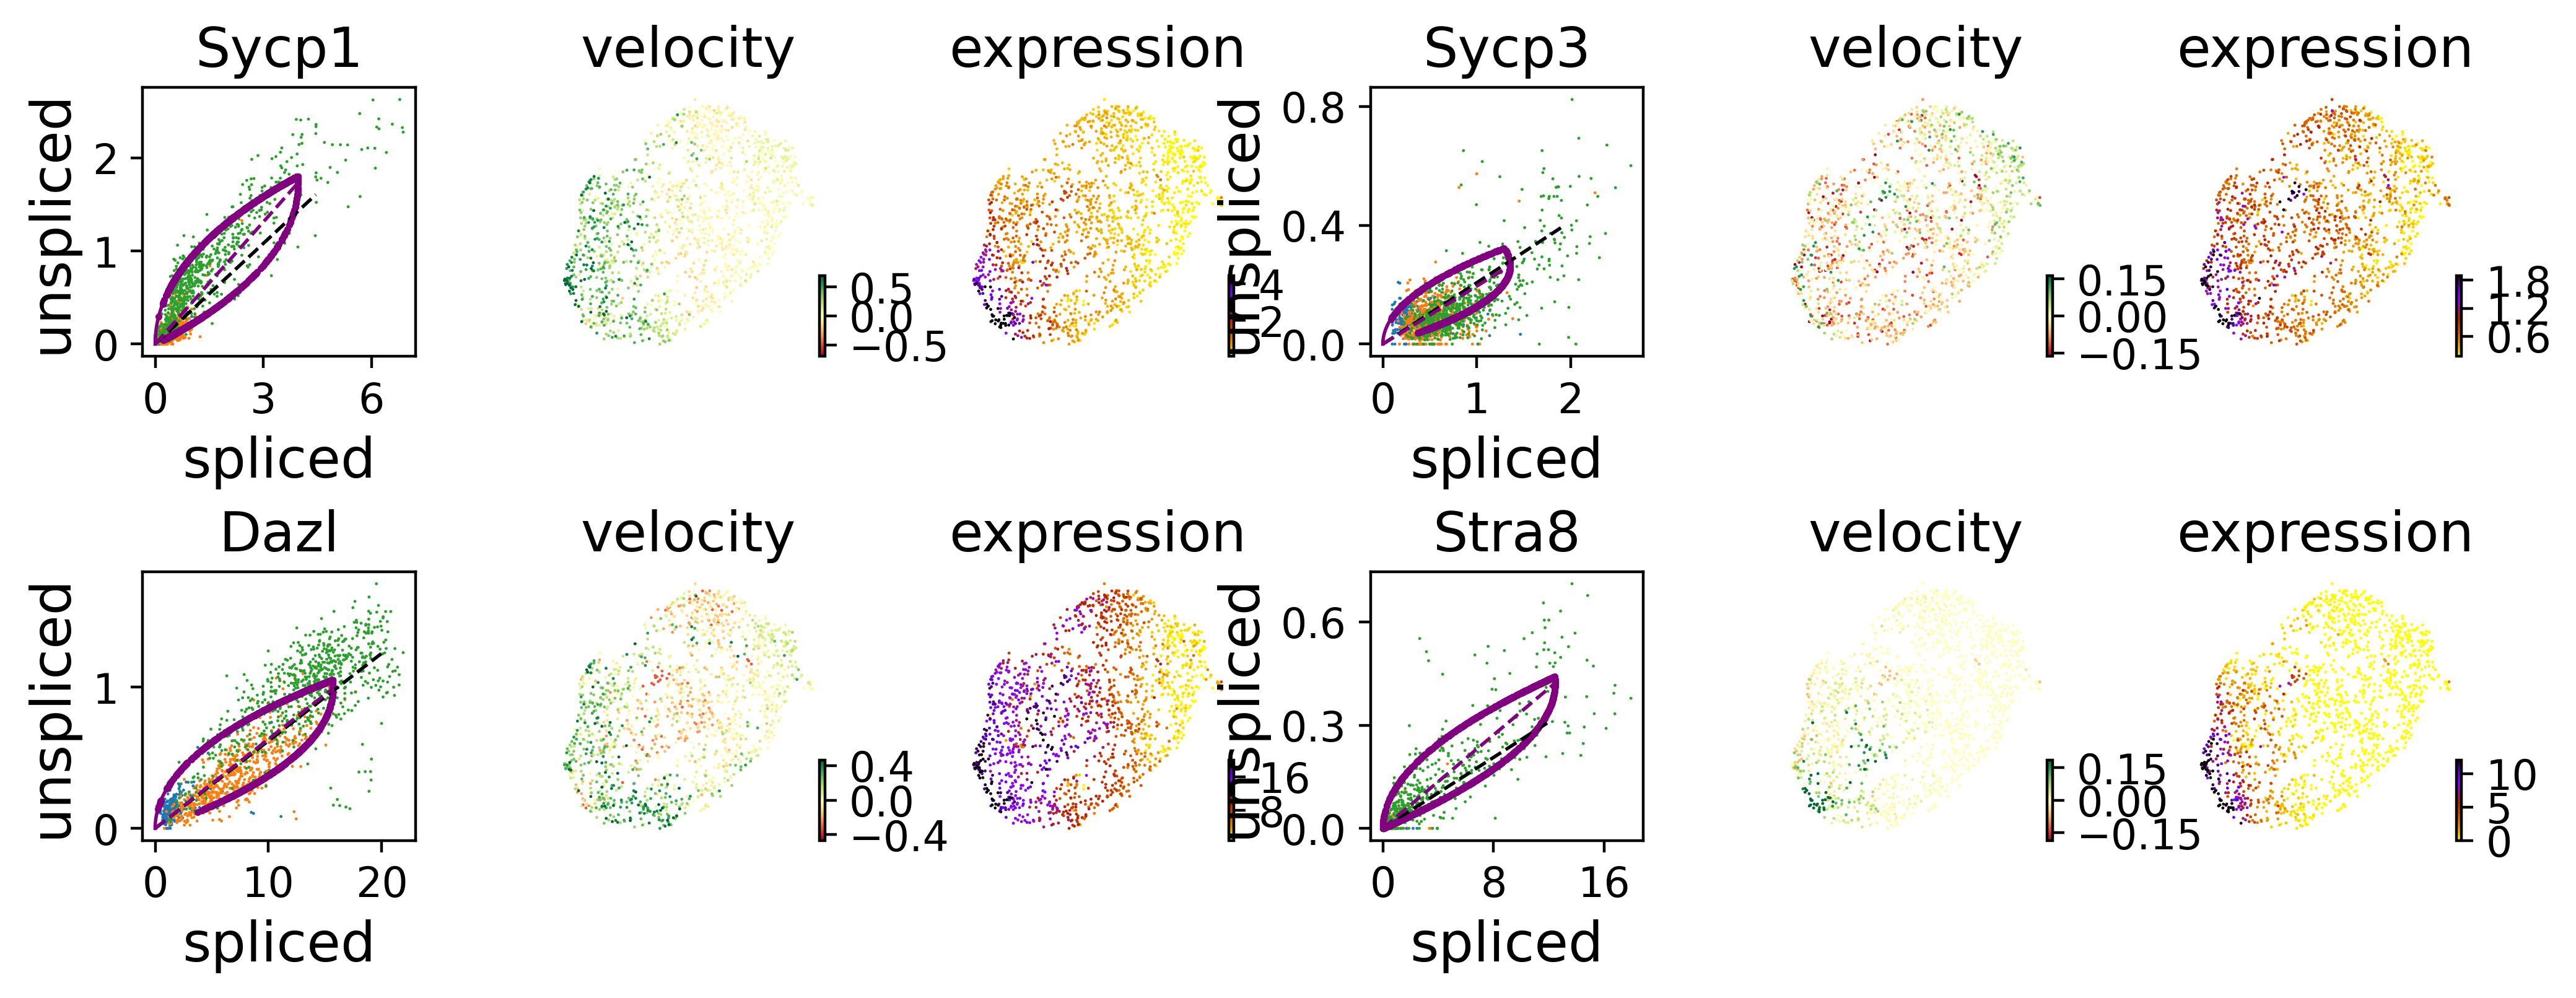

In [31]:
scv.settings.set_figure_params(fontsize=20,figsize=[4,4],dpi=200,vector_friendly=False)
scv.pl.velocity(germcells, ['Sycp1','Sycp3','Dazl','Stra8'],ncols=2,color="my_group",size = 3,ax=None,alpha=1)